In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import matplotlib.pyplot as plt

# ==== 1. Đọc dữ liệu ====
df_real = pd.read_csv(r'D:\dow\project\data\processed_iot_dataset.csv')
df_gan  = pd.read_csv(r'D:\dow\project\data\ctgan_synthetic_balanced_final.csv')

# ==== 2. Xác định feature dùng cho model ====
drop_cols = ['Sensor_ID', 'Fault_Status', 'Fault_Type', 'Year','Month','Day','Hour','Minute']
feature_cols = [c for c in df_real.columns if c not in drop_cols]

# ==== 3. Train model trên dữ liệu thật ====
model_xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model_xgb.fit(df_real[feature_cols], df_real['Fault_Status'])

# ==== 4. Dự đoán xác suất trên dữ liệu GAN ====
prob_gan = model_xgb.predict_proba(df_gan[feature_cols])[:, 1]

# ==== 5. Lọc sample GAN vùng biên (boundary) ====
threshold = 0.1
df_gan_boundary = df_gan[(prob_gan >= 0.5-threshold) & (prob_gan <= 0.5+threshold)]
print('Số sample GAN vùng biên:', len(df_gan_boundary))

# ==== 6. Gộp dữ liệu thật + GAN boundary để train lại ====
df_train = pd.concat([df_real, df_gan_boundary], ignore_index=True)

c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\dask\dataframe\__init__.py:49: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [13:09:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Số sample GAN vùng biên: 2100


In [2]:
# ==== 7. Train lại model (XGB/LGBM) và đánh giá ====
def eval_model(name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_test)[:, 1]

    # Tune threshold để tối ưu macro F1
    best_thres, best_macro_f1 = 0.5, 0
    for thres in np.arange(0.1, 0.91, 0.01):
        y_pred = (y_prob >= thres).astype(int)
        macro_f1 = f1_score(y_test, y_pred, average='macro')
        if macro_f1 > best_macro_f1:
            best_thres, best_macro_f1 = thres, macro_f1

    # Dự đoán với threshold tốt nhất
    y_pred_best = (y_prob >= best_thres).astype(int)
    print(f"\n== {name} (Train: Real+GAN boundary, Test: Real) ==")
    print(f"Best threshold: {best_thres:.2f} - Macro F1: {best_macro_f1:.4f}")
    print(classification_report(y_test, y_pred_best, digits=4))
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_best))
    print("Accuracy:", accuracy_score(y_test, y_pred_best))

    # Vẽ biểu đồ macro F1 theo threshold
    macro_f1_list, thresholds = [], []
    for thres in np.arange(0.1, 0.91, 0.01):
        y_pred = (y_prob >= thres).astype(int)
        macro_f1_list.append(f1_score(y_test, y_pred, average='macro'))
        thresholds.append(thres)
    plt.plot(thresholds, macro_f1_list, marker='o')
    plt.xlabel('Threshold')
    plt.ylabel('Macro F1-score')
    plt.title(f'{name} - Macro F1 vs Threshold (Test on Real)')
    plt.show()


c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [13:09:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



== XGBoost (Train: Real+GAN boundary, Test: Real) ==
Best threshold: 0.36 - Macro F1: 0.7229
              precision    recall  f1-score   support

           0     0.8252    0.8578    0.8412     33793
           1     0.6353    0.5768    0.6046     14509

    accuracy                         0.7734     48302
   macro avg     0.7302    0.7173    0.7229     48302
weighted avg     0.7682    0.7734    0.7701     48302

Confusion matrix:
 [[28988  4805]
 [ 6140  8369]]
Accuracy: 0.7734048279574345


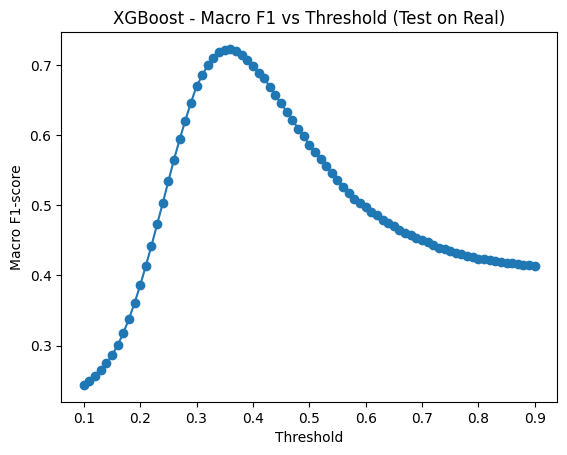

c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py:131: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py", line 247, in _count_physical_cores
    cpu_count_physical = _count_physical_cores_win32()
  File "c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py", line 299, in _count_physical_cores_win32
    cpu_info = subprocess.run(
  File "c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 501, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\Dell\App

[LightGBM] [Info] Number of positive: 16609, number of negative: 33793
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 50402, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.329531 -> initscore=-0.710309
[LightGBM] [Info] Start training from score -0.710309

== LightGBM (Train: Real+GAN boundary, Test: Real) ==
Best threshold: 0.33 - Macro F1: 0.6332
              precision    recall  f1-score   support

           0     0.7768    0.7940    0.7853     33793
           1     0.4942    0.4687    0.4811     14509

    accuracy                         0.6963     48302
   macro avg     0.6355    0.6314    0.6332     48302
weighted avg     0.6920    0.6963    0.6940     48302

Confusion matrix:
 [[26833  6960]
 [ 7708  6801]]
Accuracy: 0.696327274232951


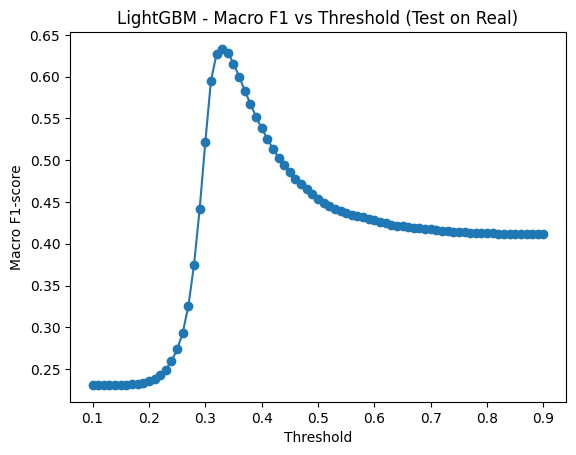

In [3]:
# ==== 8. Đánh giá trên dữ liệu thật (test) ====
X_train, y_train = df_train[feature_cols], df_train['Fault_Status']
X_test, y_test   = df_real[feature_cols], df_real['Fault_Status']

eval_model('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
           X_train, y_train, X_test, y_test)

eval_model('LightGBM', LGBMClassifier(random_state=42),
           X_train, y_train, X_test, y_test)